<a href="https://colab.research.google.com/github/UN-GCPDS/python-gcpds.EEG_Tensorflow_models/blob/main/Experimental/DW_LCAM/%5B4%5D_Main_inter_subject_variability_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load drive

In [ ]:
#-------------------------------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')
#-------------------------------------------------------------------------------

Mounted at /content/drive


# Supporting modules

In [ ]:
#-------------------------------------------------------------------------------
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from matplotlib import cm
from sklearn.model_selection import ShuffleSplit
from tensorflow import keras
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
%matplotlib inline
#-------------------------------------------------------------------------------

# Load attention maps data 




In [ ]:
Nsbj = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,
        26,27,28,30,31,32,33,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52]
rel_model_name = ['Gradcam++','Scorecam','Saliency'] 

Xw  = []
Xgc = []
Xsc = []
Xsm = []
Xt  = []
for sbj in range(len(Nsbj)):
  print('Subject:', Nsbj[sbj])
  # load weight data
  path_0= '/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/resulting_attention_maps/score_wmaps_'+str(Nsbj[sbj])+'.pickle'  
  with open(path_0, 'rb') as f:
    scores_w = pickle.load(f)
  tmp_ = scores_w[1][0]
  Xw.append(tmp_.reshape(-1))
  # load attention maps data
  path_= '/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/resulting_attention_maps/score_attmaps_'+str(Nsbj[sbj])+'.pickle'  
  with open(path_, 'rb') as f:
    scores = pickle.load(f)
  # Gradcam++
  tmp0 = scores[1][0]
  Xgc.append(tmp0.reshape(-1))
  # Scorecam
  tmp1 = scores[1][1]
  Xsc.append(tmp1.reshape(-1))
  # saliency
  tmp2 = scores[1][2]
  Xsm.append(tmp2.reshape(-1))
  # hadamard product
  tmp3 = np.multiply(tmp_,tmp0)
  tmp4 = np.multiply(tmp3,tmp1)
  tmp5 = np.multiply(tmp4,tmp2)
  Xt.append(tmp5.reshape(-1))
# from list to array
Xw  = np.array(Xw)
Xgc = np.array(Xgc)
Xsc = np.array(Xsc)
Xsm = np.array(Xsm)
Xt  = np.array(Xt)

# CKA

In [ ]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import matplotlib.pyplot as plt
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow_probability as tfp
from sklearn.decomposition import PCA
from tensorflow.keras import regularizers
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import train_test_split
tf.keras.backend.clear_session()
tf.random.set_seed(123)
import types
import tempfile
class Keras_CKA2(BaseEstimator, TransformerMixin):
	def __init__(self,epochs=200,batch_size=30,Q=0.9,learning_rate=1e-3,optimizer='Adam',
		  l1_param=0,l2_param=0,validation_split=0.2,gamma=1.0,verbose=1,init_='def_keras',gamma_y=1e-13):
		self.epochs = epochs
		self.gamma = gamma
		self.gamma_y = gamma_y
		self.batch_size = batch_size
		self.learning_rate=learning_rate 
		self.l1_param=l1_param 
		self.l2_param=l2_param
		self.validation_split = validation_split
		self.verbose = verbose
		self.optimizer = optimizer
		self.Q=Q
		self.init_=init_
  	# Define custom loss
	def custom_cka_loss(self,y_true,y_pred): #ytrue labels, ypred  = Xw
		####gradiente##########################################
		scalar_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude=1, length_scale=self.gamma)
		scalar_kernely = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude=1, length_scale=self.gamma_y)
		k = scalar_kernel.matrix(y_pred, y_pred)
		l = scalar_kernely.matrix(y_true, y_true)
		######################################################
		N = tf.shape(l)[0]
		N2 = tf.cast(tf.shape(l)[0],dtype=tf.float32)
		h = tf.eye(N) - (1.0/N2)*tf.ones([N,1])*tf.ones([1,N]) #matrix for centered kernel
		trkl = tf.linalg.trace(tf.matmul(tf.matmul(k,h),tf.matmul(l,h)))
		trkk = tf.linalg.trace(tf.matmul(tf.matmul(k,h),tf.matmul(k,h)))
		trll = tf.linalg.trace(tf.matmul(tf.matmul(l,h),tf.matmul(l,h)))
		#####funcion de costo############################################3
		f     = -trkl/tf.sqrt(trkk*trll)# negative cka cost function (minimizing) f \in [-1,0]
		return f
	def fit(self,X,Y):
		#input X numpy array first dimension Trials x features1 x features2.
		#input Y numpy array vector len = Trials.
		if self.optimizer == "Adam":
			opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
		elif self.optimizer == "SGD":
			opt = tf.keras.optimizers.SGD(learning_rate=self.learning_rate)
		else:
			opt=self.optimizer
		# split train and test
		X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=self.validation_split, random_state=0)
		if self.init_ == 'pca':
			pca_2 = PCA(n_components=self.Q, random_state = 0)
			pca_2.fit(X_train.reshape((X_train.shape[0],-1)))
			self.init_ = pca_2.components_.T
			self.Q = pca_2.n_components_
		else:
			if self.Q<1:
				pca_1 = PCA(n_components=self.Q, random_state = 0)
				pca_1.fit(X_train.reshape((X_train.shape[0],-1)))
				self.Q = pca_1.n_components_
		if len(tf.shape(X_train))>2:
			input_layer = tf.keras.layers.Input(shape=[X_train.shape[1],X_train.shape[2]])
			flatten_layer = tf.keras.layers.Flatten(input_shape=(X_train.shape[1],X_train.shape[2]))(input_layer)
			if self.init_ == 'def_keras':
				output_layer = tf.keras.layers.Dense(self.Q, activation="linear", 
					kernel_regularizer=regularizers.l1_l2(l1=self.l1_param, l2=self.l2_param), 
					use_bias=False, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=0), name= 'Proj')(flatten_layer)
			else:
				output_layer = tf.keras.layers.Dense(self.Q, activation="linear", 
					kernel_regularizer=regularizers.l1_l2(l1=self.l1_param, l2=self.l2_param),
					use_bias=False, weights=[self.init_], name= 'Proj')(flatten_layer)
		else:
			input_layer = tf.keras.layers.Input(shape = [X_train.shape[1]])
			if self.init_ == 'def_keras':
				output_layer = tf.keras.layers.Dense(self.Q, activation="linear", 
					kernel_regularizer=regularizers.l1_l2(l1=self.l1_param, l2=self.l2_param), 
					use_bias=False, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=0), name= 'Proj')(input_layer)
			else:
				output_layer = tf.keras.layers.Dense(self.Q, activation="linear", 
					kernel_regularizer=regularizers.l1_l2(l1=self.l1_param, l2=self.l2_param),
					use_bias=False, weights=[self.init_], name= 'Proj')(input_layer)
		self.model = tf.keras.Model(inputs=input_layer,outputs=output_layer)
		self.model.compile(loss=self.custom_cka_loss, optimizer=opt)
		keys = [weight.name for layer in self.model.layers for weight in layer.weights]
		weights_in = self.model.get_weights()
		self.A_in = {}
		for key, weight in zip(keys, weights_in):
			self.A_in[key] = weight 
		self.history = self.model.fit(X_train, y_train, epochs=self.epochs,
					validation_data=(X_test, y_test),batch_size=self.batch_size,
										verbose=self.verbose)
		weights_out = self.model.get_weights()
		self.A_out = {}
		for key, weight in zip(keys, weights_out):
			self.A_out[key] = weight
		return self
	def transform(self, X, *_):
		Xr = self.model.predict(X)
		return  Xr
	def fit_transform(self,X,y):
		self.fit(X,y)
		return  self.transform(X)
	def plot_history(self):
		plt.plot(self.history.history['loss'],label='loss')
		plt.plot(self.history.history['val_loss'],label='val_loss')
		plt.legend()
		return
	def __getstate__(self):
		model_str = ""
		with tempfile.NamedTemporaryFile(suffix='.h5', delete=True) as fd:
			try:
				self.model.save(fd.name,save_format='h5')
				model_str = fd.read()
			except:
				model_str='model no trained'
				self.A_out='model no trained'
				self.A_in='model no trained'
		d = { 'model_str': model_str,
		'A_in':self.A_in,
		'A_out':self.A_out,
		'gamma':self.gamma,
		'gamma_y':self.gamma_y,
		'epochs':self.epochs,
		'batch_size':self.batch_size,
		'learning_rate':self.learning_rate,
		'l1_param':self.l1_param,
		'l2_param':self.l2_param,
		'validation_split':self.validation_split,
		'verbose':self.verbose,
		'optimizer':self.optimizer,
		'Q':self.Q,
		'init_':self.init_}
		return d
	def __setstate__(self, state):
		self.gamma=state['gamma']
		self.gamma_y=state['gamma_y']
		self.epochs=state['epochs']
		self.batch_size=state['batch_size']
		self.learning_rate=state['learning_rate']
		self.l1_param=state['l1_param']
		self.l2_param=state['l2_param']
		self.validation_split=state['validation_split']
		self.verbose=state['verbose']
		self.optimizer=state['optimizer']
		self.Q=state['Q']
		self.init_=state['init_']
		with tempfile.NamedTemporaryFile(suffix='.h5', delete=True) as fd:
			try:
				fd.write(state['model_str'])
				fd.flush()
				self.model = tf.keras.models.load_model(fd.name,custom_objects={'custom_cka_loss': self.custom_cka_loss})	
				self.A_in=state['A_in']
				self.A_out=state['A_out']
			except:
				self.mode=state['model_str']
				#print(state['model_str'])

In [ ]:
#-------------------------------------------------------------------------------
def plot_attention(tmpr_,rel_model_name,layer_name,list_class,figsize=(10,5), transpose=False):
    
    names_feats = [r'CWT-$\mu$-TW1',r'CWT-$\beta$-TW1',r'CWT-$\mu$-TW2',r'CWT-$\beta$-TW2',r'CWT-$\mu$-TW3',r'CWT-$\beta$-TW3',r'CWT-$\mu$-TW4',r'CWT-$\beta$-TW4',r'CWT-$\mu$-TW5',r'CWT-$\beta$-TW5',
                   r'CSP-$\mu$-TW1',r'CSP-$\beta$-TW1',r'CSP-$\mu$-TW2',r'CSP-$\beta$-TW2',r'CSP-$\mu$-TW3',r'CSP-$\beta$-TW3',r'CSP-$\mu$-TW4',r'CSP-$\beta$-TW4',r'CSP-$\mu$-TW5',r'CSP-$\beta$-TW5']
    if transpose:
      x_label_list = layer_name 
      nC = len(list_class)
      nl = len(layer_name)
      ncols,nrows = tmpr_.shape

      y_label_list = []
      for ii in range(nC):
          y_label_list += str(list_class[ii])

      dw = nrows/nl
      list_xticks = []
      for ii in range(nl):
        list_xticks += [int(dw*(0.5+ii))]
      dw = ncols/nC
      list_yticks = []
      for ii in range(nC):
        list_yticks += [int(dw*(0.5+ii))]

    else:
      y_label_list = layer_name 
      nC = len(list_class)
      nl = len(layer_name)
      nrows,ncols = tmpr_.shape

      x_label_list = []
      for ii in range(nC):
          x_label_list += str(list_class[ii])

      dw = nrows/nl
      list_yticks = []
      for ii in range(nl):
        list_yticks += [int(dw*(0.5+ii))]
      dw = ncols/nC
      list_xticks = []
      for ii in range(nC):
        list_xticks += [int(dw*(0.5+ii))]
    
    plt.figure(figsize=figsize)
    ax = plt.gca()
    im = ax.imshow(tmpr_)#,vmin=0.0, vmax=0.3
    im = ax.imshow(tmpr_)#,vmin=0.0, vmax=0.3
    ax.set_yticks(list_yticks)
    ax.set_yticklabels(y_label_list)
    ax.set_xticks(list_xticks)
    ax.set_xticklabels(names_feats, rotation='vertical')
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad=0.1)
        
    #plt.colorbar(im, cax=cax,extend='both',
    #             ticks=[np.round(tmpr_.min(),3), np.round(0.5*(tmpr_.max()-tmpr_.min()),3), np.round(tmpr_.max(),3)])
    #plt.xticks(rotation=90)
    #plt.savefig('/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/relevance_attention_map_w.svg', format='svg')
    #plt.savefig('/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/average_map_g3.svg', format='svg')
       
    plt.tight_layout()    
    plt.show()
#-------------------------------------------------------------------------------

# Data for CKA

In [ ]:
#-------------------------------------------------------------------------------
sc      = StandardScaler()
acc_sbj = [81.7,50.0,98.3,81.7,86.7,81.5,56.9,68.3,77.8,78.3,
           61.6,88.9,75.0,93.3,87.7,66.7,66.7,63.3,73.3,66.7, 
           90.0,78.3,71.6,70.0,76.6,81.6,75.4,88.3,69.2,76.6,
           56.6,65.0,80.0,91.6,71.6,60.0,76.6,58.3,96.6,71.6,
           91.6,81.6,76.6,84.7,75.0,81.6,80.0,90.0,73.3,66.6]
acc_sbj1 = acc_sbj.copy()
# attetion maps concatenados
#Xraw = np.concatenate((Xgc,Xsc,Xsm),axis=1)
#-------------------------------------------------------------------------------
from sklearn.model_selection import KFold
from scipy.spatial.distance import pdist, squareform
# estimating average gamma_y value using 10 subsets
skf     = KFold(n_splits=10, shuffle=True, random_state=123)
#-------------------------------------------------------------------------------
acc_sbj = np.array(acc_sbj).reshape(-1, 1)
acc_sbj = sc.fit_transform(acc_sbj)
gamma_y = []
for train_index, valid_index in skf.split(acc_sbj):
  dd = pairwise_distances(acc_sbj[valid_index],acc_sbj[valid_index])
  d  = 0.5*(dd+dd.T) 
  d  = d-np.diag(np.diag(d))  
  gamma_y.append(np.median(squareform(d)))
gamma_y_YT = np.mean(np.array(gamma_y))
print('Average gamma_y using accuracies:',gamma_y_YT)
gamma_y_YT = np.float32(gamma_y_YT)
#-------------------------------------------------------------------------------

# CKA Xraw W

In [ ]:
#-------------------------------------------------------------------------------
# define cka parameters
epochs           = 300
batch_size       = 256
learning_rate    = 1e-3
l1               = 5e-3
l2               = l1
validation_split = 0.1
verbose          = 50
Q                = 0.9 # num of subjects to fix dimensions
#-------------------------------------------------------------------------------
# define cka
redcka           = Keras_CKA2(epochs=epochs,batch_size=batch_size,Q=Q,learning_rate=learning_rate,
                              l1_param=l1,l2_param=l2,validation_split=validation_split,verbose=verbose,gamma_y=gamma_y_YT)
#-------------------------------------------------------------------------------
# apply cka to data
redcka.fit_transform(Xw,acc_sbj)
#-------------------------------------------------------------------------------
# apply cka to data
zxtt  = redcka.transform(Xw)
zxtt2 = PCA(n_components=2).fit_transform(zxtt)
# computing rho (relevance feature vector)
rho   = abs(redcka.A_out['Proj/kernel:0']).sum(axis=1)
rho   -= min(rho)
rho   /=max(rho)
print('rho dimension:',rho.shape)
#-------------------------------------------------------------------------------
# plotting results
plt.figure(figsize=(10,10))
# cka performance
plt.subplot(221)
redcka.plot_history()
plt.title('cka loss')
# projected cka in pca 2d using probs as color
plt.subplot(222)
plt.scatter(zxtt2[:,0],zxtt2[:,1],c=acc_sbj1)
plt.colorbar()
plt.title('cka+pca 2D eeg features-c=Accs')
# relevance vector rho
plt.subplot(223)
plt.plot(rho)
plt.xlabel('eeg_cnn_feature')
plt.ylabel('cka_relevance')
plt.title('cka relevance')
# projected cka in pca 2d using id subjects as color
plt.subplot(224)
plt.scatter(zxtt2[:,0],zxtt2[:,1],c=Nsbj)
plt.colorbar()
plt.title('cka+pca 2D eeg features-c=sID')

plt.subplots_adjust(hspace=0.3,wspace=0.4)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/cka_attention_map_w.svg', format='svg')
plt.show()

#-------------------------------------------------------------------------------

In [ ]:
# correlation
np.corrcoef(zxtt2[:,0].reshape(-1),acc_sbj.reshape(-1))

In [ ]:
# reshape rho vector
new_rho = rho.reshape((80,800))
layer_name     = ['conv2d','conv2d_1','conv2d_2','conv2d_3','conv2d_4','conv2d_5','conv2d_6','conv2d_7','conv2d_8','conv2d_9','conv2d_10',
                   'conv2d_11','conv2d_12','conv2d_13','conv2d_14','conv2d_15','conv2d_16','conv2d_17','conv2d_18','conv2d_19']
list_class = [0,1]
plot_attention(new_rho,'Weights',layer_name,list_class,transpose=True)
#-------------------------------------------------------------------------------

# CKA Xraw gc

In [ ]:
#-------------------------------------------------------------------------------
# define cka parameters
epochs           = 300
batch_size       = 256
learning_rate    = 1e-3
l1               = 5e-3
l2               = l1
validation_split = 0.2
verbose          = 50
Q                = 0.9 # num of subjects to fix dimensions
#-------------------------------------------------------------------------------
# define cka
redcka           = Keras_CKA2(epochs=epochs,batch_size=batch_size,Q=Q,learning_rate=learning_rate,
                              l1_param=l1,l2_param=l2,validation_split=validation_split,verbose=verbose,gamma_y=gamma_y_YT)
#-------------------------------------------------------------------------------
# apply cka to data
redcka.fit_transform(Xgc,acc_sbj)
#-------------------------------------------------------------------------------
# apply cka to data
zxtt  = redcka.transform(Xgc)
zxtt2 = PCA(n_components=2).fit_transform(zxtt)
# computing rho (relevance feature vector)
rho   = abs(redcka.A_out['Proj/kernel:0']).sum(axis=1)
rho   -= min(rho)
rho   /=max(rho)
print('rho dimension:',rho.shape)
#-------------------------------------------------------------------------------
# plotting results
plt.figure(figsize=(10,10))
# cka performance
plt.subplot(221)
redcka.plot_history()
plt.title('cka loss')
# projected cka in pca 2d using probs as color
plt.subplot(222)
plt.scatter(zxtt2[:,0],zxtt2[:,1],c=acc_sbj1)
plt.colorbar()
plt.title('cka+pca 2D eeg features-c=Accs')
# relevance vector rho
plt.subplot(223)
plt.plot(rho)
plt.xlabel('eeg_cnn_feature')
plt.ylabel('cka_relevance')
plt.title('cka relevance')
# projected cka in pca 2d using id subjects as color
plt.subplot(224)
plt.scatter(zxtt2[:,0],zxtt2[:,1],c=Nsbj)
plt.colorbar()
plt.title('cka+pca 2D eeg features-c=sID')

plt.subplots_adjust(hspace=0.3,wspace=0.4)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/cka_attention_map_gc.svg', format='svg')
plt.show()

#-------------------------------------------------------------------------------

In [ ]:
# correlation
np.corrcoef(zxtt2[:,0].reshape(-1),acc_sbj.reshape(-1))

In [ ]:
# reshape rho vector
new_rho = rho.reshape((80,800))
layer_name     = ['conv2d','conv2d_1','conv2d_2','conv2d_3','conv2d_4','conv2d_5','conv2d_6','conv2d_7','conv2d_8','conv2d_9','conv2d_10',
                   'conv2d_11','conv2d_12','conv2d_13','conv2d_14','conv2d_15','conv2d_16','conv2d_17','conv2d_18','conv2d_19']
list_class = [0,1]
plot_attention(new_rho,'GradCam++',layer_name,list_class,transpose=True)
#-------------------------------------------------------------------------------

# CKA Xraw sc

In [ ]:
#-------------------------------------------------------------------------------
# define cka parameters
epochs           = 300
batch_size       = 256
learning_rate    = 1e-3
l1               = 5e-3
l2               = l1
validation_split = 0.2
verbose          = 50
Q                = 0.9 # num of subjects to fix dimensions
#-------------------------------------------------------------------------------
# define cka
redcka           = Keras_CKA2(epochs=epochs,batch_size=batch_size,Q=Q,learning_rate=learning_rate,
                              l1_param=l1,l2_param=l2,validation_split=validation_split,verbose=verbose,gamma_y=gamma_y_YT)
#-------------------------------------------------------------------------------
# apply cka to data
redcka.fit_transform(Xsc,acc_sbj)
#-------------------------------------------------------------------------------
# apply cka to data
zxtt  = redcka.transform(Xsc)
zxtt2 = PCA(n_components=2).fit_transform(zxtt)
# computing rho (relevance feature vector)
rho   = abs(redcka.A_out['Proj/kernel:0']).sum(axis=1)
rho   -= min(rho)
rho   /=max(rho)
print('rho dimension:',rho.shape)
#-------------------------------------------------------------------------------
# plotting results
plt.figure(figsize=(10,10))
# cka performance
plt.subplot(221)
redcka.plot_history()
plt.title('cka loss')
# projected cka in pca 2d using probs as color
plt.subplot(222)
plt.scatter(zxtt2[:,0],zxtt2[:,1],c=acc_sbj1)
plt.colorbar()
plt.title('cka+pca 2D eeg features-c=Accs')
# relevance vector rho
plt.subplot(223)
plt.plot(rho)
plt.xlabel('eeg_cnn_feature')
plt.ylabel('cka_relevance')
plt.title('cka relevance')
# projected cka in pca 2d using id subjects as color
plt.subplot(224)
plt.scatter(zxtt2[:,0],zxtt2[:,1],c=Nsbj)
plt.colorbar()
plt.title('cka+pca 2D eeg features-c=sID')

plt.subplots_adjust(hspace=0.3,wspace=0.4)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/cka_attention_map_sc.svg', format='svg')
plt.show()

#-------------------------------------------------------------------------------

In [ ]:
# correlation
np.corrcoef(zxtt2[:,0].reshape(-1),acc_sbj.reshape(-1))

In [ ]:
# reshape rho vector
new_rho = rho.reshape((80,800))
layer_name     = ['conv2d','conv2d_1','conv2d_2','conv2d_3','conv2d_4','conv2d_5','conv2d_6','conv2d_7','conv2d_8','conv2d_9','conv2d_10',
                   'conv2d_11','conv2d_12','conv2d_13','conv2d_14','conv2d_15','conv2d_16','conv2d_17','conv2d_18','conv2d_19']
list_class = [0,1]
plot_attention(new_rho,'ScoreCam',layer_name,list_class,transpose=True)

# CKA Xraw sm

In [ ]:
#-------------------------------------------------------------------------------
# define cka parameters
epochs           = 300
batch_size       = 256
learning_rate    = 1e-3
l1               = 5e-3
l2               = l1
validation_split = 0.1
verbose          = 50
Q                = 0.9 # num of subjects to fix dimensions
#-------------------------------------------------------------------------------
# define cka
redcka           = Keras_CKA2(epochs=epochs,batch_size=batch_size,Q=Q,learning_rate=learning_rate,
                              l1_param=l1,l2_param=l2,validation_split=validation_split,verbose=verbose,gamma_y=gamma_y_YT)
#-------------------------------------------------------------------------------
# apply cka to data
redcka.fit_transform(Xsm,acc_sbj)
#-------------------------------------------------------------------------------
# apply cka to data
zxtt  = redcka.transform(Xsm)
zxtt2 = PCA(n_components=2).fit_transform(zxtt)
# computing rho (relevance feature vector)
rho   = abs(redcka.A_out['Proj/kernel:0']).sum(axis=1)
rho   -= min(rho)
rho   /=max(rho)
print('rho dimension:',rho.shape)
#-------------------------------------------------------------------------------
# plotting results
plt.figure(figsize=(10,10))
# cka performance
plt.subplot(221)
redcka.plot_history()
plt.title('cka loss')
# projected cka in pca 2d using probs as color
plt.subplot(222)
plt.scatter(zxtt2[:,0],zxtt2[:,1],c=acc_sbj1)
plt.colorbar()
plt.title('cka+pca 2D eeg features-c=Accs')
# relevance vector rho
plt.subplot(223)
plt.plot(rho)
plt.xlabel('eeg_cnn_feature')
plt.ylabel('cka_relevance')
plt.title('cka relevance')
# projected cka in pca 2d using id subjects as color
plt.subplot(224)
plt.scatter(zxtt2[:,0],zxtt2[:,1],c=Nsbj)
plt.colorbar()
plt.title('cka+pca 2D eeg features-c=sID')

plt.subplots_adjust(hspace=0.3,wspace=0.4)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/cka_attention_map_sm.svg', format='svg')
plt.show()

#-------------------------------------------------------------------------------

In [ ]:
# correlation
np.corrcoef(zxtt2[:,0].reshape(-1),acc_sbj.reshape(-1))

In [ ]:
# reshape rho vector
new_rho = rho.reshape((80,800))
layer_name     = ['conv2d','conv2d_1','conv2d_2','conv2d_3','conv2d_4','conv2d_5','conv2d_6','conv2d_7','conv2d_8','conv2d_9','conv2d_10',
                   'conv2d_11','conv2d_12','conv2d_13','conv2d_14','conv2d_15','conv2d_16','conv2d_17','conv2d_18','conv2d_19']
list_class = [0,1]
plot_attention(new_rho,'Saliency map',layer_name,list_class,transpose=True)

# CKA raw hadamard product

In [ ]:
#-------------------------------------------------------------------------------
# define cka parameters
epochs           = 300
batch_size       = 256
learning_rate    = 1e-3
l1               = 5e-3
l2               = l1
validation_split = 0.1
verbose          = 50
Q                = 0.95 # num of subjects to fix dimensions
#-------------------------------------------------------------------------------
# define cka
redcka           = Keras_CKA2(epochs=epochs,batch_size=batch_size,Q=Q,learning_rate=learning_rate,
                              l1_param=l1,l2_param=l2,validation_split=validation_split,verbose=verbose,gamma_y=gamma_y_YT)
#-------------------------------------------------------------------------------
# apply cka to data
redcka.fit_transform(Xt,acc_sbj)
#-------------------------------------------------------------------------------
# apply cka to data
zxtt  = redcka.transform(Xt)
with open('/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/CKA_hp_data_inter.pickle', 'wb') as f:
            pickle.dump(zxtt, f)
zxtt2 = PCA(n_components=2).fit_transform(zxtt)
# computing rho (relevance feature vector)
rho   = abs(redcka.A_out['Proj/kernel:0']).sum(axis=1)
rho   -= min(rho)
rho   /=max(rho)
print('rho dimension:',rho.shape)
#-------------------------------------------------------------------------------
# plotting results
plt.figure(figsize=(10,10))
# cka performance
plt.subplot(221)
redcka.plot_history()
plt.title('cka loss')
# projected cka in pca 2d using probs as color
plt.subplot(222)
plt.scatter(zxtt2[:,0],zxtt2[:,1],c=acc_sbj1)
plt.colorbar()
plt.title('cka+pca 2D eeg features-c=Accs')
# relevance vector rho
plt.subplot(223)
plt.plot(rho)
plt.xlabel('eeg_cnn_feature')
plt.ylabel('cka_relevance')
plt.title('cka relevance')
# projected cka in pca 2d using id subjects as color
plt.subplot(224)
plt.scatter(zxtt2[:,0],zxtt2[:,1],c=Nsbj)
plt.colorbar()
plt.title('cka+pca 2D eeg features-c=sID')

plt.subplots_adjust(hspace=0.3,wspace=0.4)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/cka_attention_map_hp.svg', format='svg')
plt.show()

#-------------------------------------------------------------------------------

In [ ]:
# correlation
np.corrcoef(zxtt2[:,0].reshape(-1),acc_sbj.reshape(-1))

In [ ]:
# reshape rho vector
new_rho = rho.reshape((80,800))
layer_name     = ['conv2d','conv2d_1','conv2d_2','conv2d_3','conv2d_4','conv2d_5','conv2d_6','conv2d_7','conv2d_8','conv2d_9','conv2d_10',
                   'conv2d_11','conv2d_12','conv2d_13','conv2d_14','conv2d_15','conv2d_16','conv2d_17','conv2d_18','conv2d_19']
list_class = [0,1]
plot_attention(new_rho,'Hadamard product',layer_name,list_class,transpose=True)

# K-means

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4).fit(zxtt2)
labels = kmeans.predict(zxtt2)
plt.figure(figsize=(5,6))
plt.scatter(zxtt2[:,0],zxtt2[:,1],c=labels)
plt.colorbar()

In [ ]:
print('Subjects group 0:',np.array(Nsbj)[labels==0])
print('Subjects group 1:',np.array(Nsbj)[labels==1])
print('Subjects group 2:',np.array(Nsbj)[labels==2])
print('Subjects group 3:',np.array(Nsbj)[labels==3])

# Spectral clustering

In [ ]:
from sklearn.cluster import SpectralClustering
Nsbj = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,
        26,27,28,30,31,32,33,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52]
clustering = SpectralClustering(n_clusters=4, gamma=1).fit(zxtt2)
clustering.labels_
plt.figure(figsize=(5,6))
plt.scatter(zxtt2[:,0],zxtt2[:,1],c=clustering.labels_)
plt.colorbar()
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/spectral_clus.svg', format='svg')

In [ ]:
print('Subjects group 0:',np.array(Nsbj)[clustering.labels_==0],'- Acc:',np.mean(np.array(acc_sbj1)[clustering.labels_==0]))
print('Subjects group 1:',np.array(Nsbj)[clustering.labels_==1],'- Acc:',np.mean(np.array(acc_sbj1)[clustering.labels_==1]))
print('Subjects group 2:',np.array(Nsbj)[clustering.labels_==2],'- Acc:',np.mean(np.array(acc_sbj1)[clustering.labels_==2]))
print('Subjects group 3:',np.array(Nsbj)[clustering.labels_==3],'- Acc:',np.mean(np.array(acc_sbj1)[clustering.labels_==3]))

In [ ]:
g_verde    = [3,4,5,6,10,14,23,26,41,43,44,46,48,49,50]
g_amarillo = [1,2,11,12,13,15,19,20,21,22,25,28,31,35,36,37,39,47,52]
g_rojo     = [7,8,9,16,17,18,24,27,30,32,33,38,40,42,45,51]

new_idxs = []
for i in range(len(Nsbj)):
  if np.isin(Nsbj[i], g_verde):
    new_idxs.append('green')
  elif np.isin(Nsbj[i], g_amarillo):
    new_idxs.append('yellow')
  else:
    new_idxs.append('red')

#alpha1= alpha2
plt.figure(figsize=(5,6))
plt.scatter(zxtt2[:,0],zxtt2[:,1],c=new_idxs)
plt.colorbar()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/new_groups.svg', format='svg')

# Average topogram per group

In [ ]:
Nsbj = [5,14,15,21,28,36,41,43,46,50]
rel_model_name = ['Gradcam++','Scorecam','Saliency'] 

Xt  = []
for sbj in range(len(Nsbj)):
  print('Subject:', Nsbj[sbj])
  # load weight data
  path_0= '/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/resulting_attention_maps/score_wmaps_'+str(Nsbj[sbj])+'.pickle'  
  with open(path_0, 'rb') as f:
    scores_w = pickle.load(f)
  tmp_ = scores_w[1][0]
  # load attention maps data
  path_= '/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/resulting_attention_maps/score_attmaps_'+str(Nsbj[sbj])+'.pickle'  
  with open(path_, 'rb') as f:
    scores = pickle.load(f)
  # Gradcam++
  tmp0 = scores[1][0]
  # Scorecam
  tmp1 = scores[1][1]
  # saliency
  tmp2 = scores[1][2]
  # hadamard product
  tmp3 = np.multiply(tmp_,tmp0)
  tmp4 = np.multiply(tmp3,tmp1)
  tmp5 = np.multiply(tmp4,tmp2)
  Xt.append(tmp5)
# from list to array
Xt  = np.mean(np.array(Xt),axis=0)
Xt  = Xt/Xt.max()
layer_name     = ['conv2d','conv2d_1','conv2d_2','conv2d_3','conv2d_4','conv2d_5','conv2d_6','conv2d_7','conv2d_8','conv2d_9','conv2d_10',
                   'conv2d_11','conv2d_12','conv2d_13','conv2d_14','conv2d_15','conv2d_16','conv2d_17','conv2d_18','conv2d_19']
list_class = [0,1]
plot_attention(Xt,'Hadamard product',layer_name,list_class,transpose=True)

In [ ]:
Nsbj = [1,3,4,6,9,10,13,19,22,23,24,25,26,27,31,35,37,39,42,45,47,48,49,51]
rel_model_name = ['Gradcam++','Scorecam','Saliency'] 

Xt  = []
for sbj in range(len(Nsbj)):
  print('Subject:', Nsbj[sbj])
  # load weight data
  path_0= '/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/resulting_attention_maps/score_wmaps_'+str(Nsbj[sbj])+'.pickle'  
  with open(path_0, 'rb') as f:
    scores_w = pickle.load(f)
  tmp_ = scores_w[1][0]
  # load attention maps data
  path_= '/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/resulting_attention_maps/score_attmaps_'+str(Nsbj[sbj])+'.pickle'  
  with open(path_, 'rb') as f:
    scores = pickle.load(f)
  # Gradcam++
  tmp0 = scores[1][0]
  # Scorecam
  tmp1 = scores[1][1]
  # saliency
  tmp2 = scores[1][2]
  # hadamard product
  tmp3 = np.multiply(tmp_,tmp0)
  tmp4 = np.multiply(tmp3,tmp1)
  tmp5 = np.multiply(tmp4,tmp2)
  Xt.append(tmp5)
# from list to array
Xt  = np.mean(np.array(Xt),axis=0)
Xt  = Xt/Xt.max()
layer_name     = ['conv2d','conv2d_1','conv2d_2','conv2d_3','conv2d_4','conv2d_5','conv2d_6','conv2d_7','conv2d_8','conv2d_9','conv2d_10',
                   'conv2d_11','conv2d_12','conv2d_13','conv2d_14','conv2d_15','conv2d_16','conv2d_17','conv2d_18','conv2d_19']
list_class = [0,1]
plot_attention(Xt,'Hadamard product',layer_name,list_class,transpose=True)

In [ ]:
Nsbj = [30]
rel_model_name = ['Gradcam++','Scorecam','Saliency'] 

Xt  = []
for sbj in range(len(Nsbj)):
  print('Subject:', Nsbj[sbj])
  # load weight data
  path_0= '/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/resulting_attention_maps/score_wmaps_'+str(Nsbj[sbj])+'.pickle'  
  with open(path_0, 'rb') as f:
    scores_w = pickle.load(f)
  tmp_ = scores_w[1][0]
  # load attention maps data
  path_= '/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/resulting_attention_maps/score_attmaps_'+str(Nsbj[sbj])+'.pickle'  
  with open(path_, 'rb') as f:
    scores = pickle.load(f)
  # Gradcam++
  tmp0 = scores[1][0]
  # Scorecam
  tmp1 = scores[1][1]
  # saliency
  tmp2 = scores[1][2]
  # hadamard product
  tmp3 = np.multiply(tmp_,tmp0)
  tmp4 = np.multiply(tmp3,tmp1)
  tmp5 = np.multiply(tmp4,tmp2)
  Xt.append(tmp5)
# from list to array
Xt  = np.mean(np.array(Xt),axis=0)
Xt  = Xt/Xt.max()
layer_name     = ['conv2d','conv2d_1','conv2d_2','conv2d_3','conv2d_4','conv2d_5','conv2d_6','conv2d_7','conv2d_8','conv2d_9','conv2d_10',
                   'conv2d_11','conv2d_12','conv2d_13','conv2d_14','conv2d_15','conv2d_16','conv2d_17','conv2d_18','conv2d_19']
list_class = [0,1]
plot_attention(Xt,'Hadamard product',layer_name,list_class,transpose=True)

In [ ]:
Nsbj = [2,7,8,11,12,16,17,18,20,32,33,38,40,44,52] 
rel_model_name = ['Gradcam++','Scorecam','Saliency'] 

Xt  = []
for sbj in range(len(Nsbj)):
  print('Subject:', Nsbj[sbj])
  # load weight data
  path_0= '/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/resulting_attention_maps/score_wmaps_'+str(Nsbj[sbj])+'.pickle'  
  with open(path_0, 'rb') as f:
    scores_w = pickle.load(f)
  tmp_ = scores_w[1][0]
  # load attention maps data
  path_= '/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/resulting_attention_maps/score_attmaps_'+str(Nsbj[sbj])+'.pickle'  
  with open(path_, 'rb') as f:
    scores = pickle.load(f)
  # Gradcam++
  tmp0 = scores[1][0]
  # Scorecam
  tmp1 = scores[1][1]
  # saliency
  tmp2 = scores[1][2]
  # hadamard product
  tmp3 = np.multiply(tmp_,tmp0)
  tmp4 = np.multiply(tmp3,tmp1)
  tmp5 = np.multiply(tmp4,tmp2)
  Xt.append(tmp5)
# from list to array
Xt  = np.mean(np.array(Xt),axis=0)
Xt  = Xt/Xt.max()
layer_name     = ['conv2d','conv2d_1','conv2d_2','conv2d_3','conv2d_4','conv2d_5','conv2d_6','conv2d_7','conv2d_8','conv2d_9','conv2d_10',
                   'conv2d_11','conv2d_12','conv2d_13','conv2d_14','conv2d_15','conv2d_16','conv2d_17','conv2d_18','conv2d_19']
list_class = [0,1]
plot_attention(Xt,'Hadamard product',layer_name,list_class,transpose=True)

In [ ]:
ac_groups = np.array([90.1,77.6,69.2,65.1])
plt.figure(figsize=(10,1))
plt.plot(np.arange(4),ac_groups)
plt.grid()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/acc_clus.svg', format='svg')

In [ ]:
corr_values = np.array([0.52,0.80,0.86,0.45,0.80])
plt.figure(figsize=(10,1))
plt.plot(np.arange(5),corr_values)
plt.grid()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/corr_val.svg', format='svg')

# Plot Acc figure

Acc FBCSP: 67.7408 5.897600000000001 32
Acc DW-CNN: 76.218 3.9614000000000003 15
Acc DW-CNN+GC++: 84.09 3.4619999999999993 6


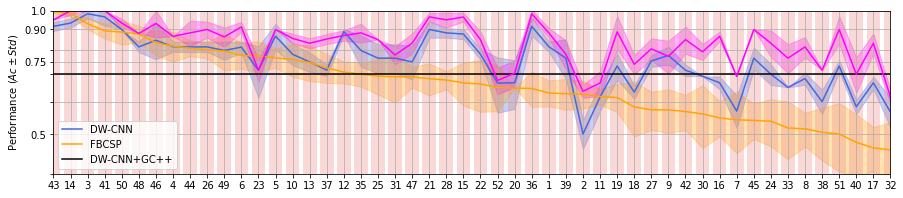

In [ ]:
import joblib
#-------------------------------------------------------------------------------
# DW-CNN
Nsbj = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,
        26,27,28,30,31,32,33,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52])

acc_sbj = np.array([81.7,50.0,98.3,81.7,86.7,81.5,56.9,68.3,77.8,78.3,
           61.6,88.9,75.0,93.3,87.7,66.7,66.7,63.3,73.3,66.7, 
           90.0,78.3,71.6,70.0,76.6,81.6,75.4,88.3,69.2,76.6,
           56.6,65.0,80.0,91.6,71.6,60.0,76.6,58.3,96.6,71.6,
           91.6,81.6,76.6,84.7,75.0,81.6,80.0,90.0,73.3,66.6])

std_sbj = np.array([2.35,4.08,2.35,2.35,6.23,2.61,5.19,2.35,3.92,4.71,
           4.71,1.42,4.08,2.35,2.48,2.35,2.35,2.35,5.44,9.07,
           4.08,2.35,10.27,4.08,6.23,2.35,2.48,2.35,0.00,6.23,
           4.71,0.00,7.07,4.71,2.35,4.08,8.49,2.35,4.71,2.35,
           2.35,2.35,4.71,8.56,7.07,2.35,4.08,0.00,2.35,10.27])

idxs = np.argsort(acc_sbj)[::-1]
#-------------------------------------------------------------------------------
# FBCSP
acc_fbcsp = model=joblib.load('Results_biclass_FBCSP_2tau_LDA_giga_acc.joblib')
acc1      = acc_fbcsp['acc']
acc       = np.array(acc1)[np.array(acc1)!=0]
stds1     = acc_fbcsp['stds']
stds      = np.array(stds1)[np.array(acc1)!=0]
idxs0     = np.argsort(acc)[::-1]
#-------------------------------------------------------------------------------
# Mask GradCam++
acc_mask_gradcam = np.array([88.3,63.6,100.0,86.6,90.0,91.3,69.1,81.6,77.4,85.6,66.6,87.0,83.3,100.0,96.5,86.6,83.3,74.0,88.8,70.4,96.6,85.0,71.6,83.3,85.0,
                    90.0,80.7,95.0,79.4,78.0,61.6,76.6,88.3,98.3,85.3,71.6,78.3,70.0,100.0,85.0,95.0,88.3,90.0,93.1,83.3,88.0,86.3,93.3,90.0,67.6])

std_mask_gradcam = np.array([2.4,2.3,0.0,0,0.0,2.6,0.0,4.7,7.1,2.3,4.7,2.6,2.4,2.3,2.4,2.3,4.7,4.0,8.3,5.2,2.3,4.0,4.7,6.2,0.0,
                    4.1,4.9,4.0,3.6,4.0,2.3,6.2,4.7,2.3,2.4,0.0,6.4,7.0,0.0,6.5,0.0,6.2,0.0,7.0,4.7,0.0,4.7,2.4,7.1,5.1])
#-------------------------------------------------------------------------------
print('Acc FBCSP:',np.mean(acc),np.mean(stds),np.sum(acc<=70))
print('Acc DW-CNN:',np.mean(acc_sbj),np.mean(std_sbj),np.sum(acc_sbj<=70))
print('Acc DW-CNN+GC++:',np.mean(acc_mask_gradcam),np.mean(std_mask_gradcam),np.sum(acc_mask_gradcam<=70))
#-------------------------------------------------------------------------------
# figure
plt.figure(figsize=(15,3))
plt.ylabel('Performance ($Ac\pm Std$)')
# plot train scores
plt.plot(np.arange(50), acc_sbj[idxs0], label='Average test accuracy',
             color='royalblue')
# create a shaded area between [mean - std, mean + std]
plt.gca().fill_between(np.arange(50),
                       acc_sbj[idxs0] - std_sbj[idxs0],
                       acc_sbj[idxs0] + std_sbj[idxs0],
                       alpha=0.3,
                       color='royalblue')

plt.plot(np.arange(50), acc[idxs0], label='Average test accuracy',
             color='orange')
# create a shaded area between [mean - std, mean + std]
plt.gca().fill_between(np.arange(50),
                       acc[idxs0] - stds[idxs0],
                       acc[idxs0] + stds[idxs0],
                       alpha=0.3,
                       color='orange')

plt.plot(np.arange(50), np.ones(50)*70.0, label='Average',
             color='black')


plt.plot(np.arange(50), acc_mask_gradcam[idxs0], label='Average test mask GC',
             color='magenta')
plt.gca().fill_between(np.arange(50),
                       np.array(acc_mask_gradcam)[idxs0] - np.array(std_mask_gradcam)[idxs0],
                       np.array(acc_mask_gradcam)[idxs0] + np.array(std_mask_gradcam)[idxs0],
                       alpha=0.3,
                       color='magenta')
'''
plt.plot(np.arange(50), acc_mask_gradcam, label='Average test mask GC',
             color='magenta')
plt.gca().fill_between(np.arange(50),
                       np.array(acc_mask_gradcam) - np.array(std_mask_gradcam),
                       np.array(acc_mask_gradcam) + np.array(std_mask_gradcam),
                       alpha=0.3,
                       color='magenta')

plt.plot(np.arange(50), acc_mask_scorecam, label='Average test mask GC',
             color='cyan')
plt.gca().fill_between(np.arange(50),
                       np.array(acc_mask_scorecam) - np.array(std_mask_scorecam),
                       np.array(acc_mask_scorecam) + np.array(std_mask_scorecam),
                       alpha=0.3,
                       color='cyan')


'''
plt.bar(np.arange(50), height=110, width=0.8,color='lightcoral',alpha=0.3)

plt.grid()
plt.xlim((0,49))
plt.xticks(np.arange(50),Nsbj[idxs0])
plt.ylim((40,100))
plt.yscale('log')
plt.yticks((40,50,60,70,75,80,90,100),['','0.5','','','0.75','','0.90','1.0'])
plt.legend(['DW-CNN','FBCSP','DW-CNN+GC++'])#,'DW-CNN GC++','DW-CNN SC'
plt.savefig('/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/new_figures/Accuracy_sbjs.svg', format='svg')

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(np.array(acc).reshape(-1, 1))
kmeans.labels_
print(Nsbj[kmeans.labels_==0])
print(Nsbj[kmeans.labels_==1])
print(Nsbj[kmeans.labels_==2])

In [ ]:
#from sklearn.externals import joblib
#-------------------------------------------------------------------------------
# DW-CNN
Nsbj = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,
        26,27,28,30,31,32,33,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52])

acc_sbj = np.array([81.7,50.0,98.3,81.7,86.7,81.5,56.9,68.3,77.8,78.3,
           61.6,88.9,75.0,93.3,87.7,66.7,66.7,63.3,73.3,66.7, 
           90.0,78.3,71.6,70.0,76.6,81.6,75.4,88.3,69.2,76.6,
           56.6,65.0,80.0,91.6,71.6,60.0,76.6,58.3,96.6,71.6,
           91.6,81.6,76.6,84.7,75.0,81.6,80.0,90.0,73.3,66.6])

std_sbj = np.array([2.35,4.08,2.35,2.35,6.23,2.61,5.19,2.35,3.92,4.71,
           4.71,1.42,4.08,2.35,2.48,2.35,2.35,2.35,5.44,9.07,
           4.08,2.35,10.27,4.08,6.23,2.35,2.48,2.35,0.00,6.23,
           4.71,0.00,7.07,4.71,2.35,4.08,8.49,2.35,4.71,2.35,
           2.35,2.35,4.71,8.56,7.07,2.35,4.08,0.00,2.35,10.27])

idxs = np.argsort(acc_sbj)[::-1]
#-------------------------------------------------------------------------------

# Mask GradCam++
acc_mask_gradcam = np.array([88.3,63.6,100.0,86.6,90.0,91.3,69.1,81.6,77.4,85.6,66.6,87.0,83.3,100.0,96.5,86.6,83.3,74.0,88.8,70.4,96.6,85.0,71.6,83.3,85.0,
                    90.0,80.7,95.0,79.4,78.0,61.6,76.6,88.3,98.3,85.3,71.6,78.3,70.0,100.0,85.0,95.0,88.3,90.0,93.1,83.3,88.0,86.3,93.3,90.0,67.6])

std_mask_gradcam = np.array([2.4,2.3,0.0,0,0.0,2.6,0.0,4.7,7.1,2.3,4.7,2.6,2.4,2.3,2.4,2.3,4.7,4.0,8.3,5.2,2.3,4.0,4.7,6.2,0.0,
                    4.1,4.9,4.0,3.6,4.0,2.3,6.2,4.7,2.3,2.4,0.0,6.4,7.0,0.0,6.5,0.0,6.2,0.0,7.0,4.7,0.0,4.7,2.4,7.1,5.1])
#-------------------------------------------------------------------------------
print('Acc FBCSP:',np.mean(acc),np.mean(stds),np.sum(acc<=70))
print('Acc DW-CNN:',np.mean(acc_sbj),np.mean(std_sbj),np.sum(acc_sbj<=70))
print('Acc DW-CNN+GC++:',np.mean(acc_mask_gradcam),np.mean(std_mask_gradcam),np.sum(acc_mask_gradcam<=70))
#-------------------------------------------------------------------------------
# figure
plt.figure(figsize=(15,3))
plt.ylabel('Performance ($Ac\pm Std$)')
# plot train scores
plt.plot(np.arange(50), acc_sbj[idxs], label='Average test accuracy',
             color='royalblue')
# create a shaded area between [mean - std, mean + std]
plt.gca().fill_between(np.arange(50),
                       acc_sbj[idxs] - std_sbj[idxs],
                       acc_sbj[idxs] + std_sbj[idxs],
                       alpha=0.3,
                       color='royalblue')


plt.plot(np.arange(50), np.ones(50)*70.0, label='Average',
             color='red')

'''
plt.plot(np.arange(50), acc_mask_gradcam, label='Average test mask GC',
             color='magenta')
plt.gca().fill_between(np.arange(50),
                       np.array(acc_mask_gradcam) - np.array(std_mask_gradcam),
                       np.array(acc_mask_gradcam) + np.array(std_mask_gradcam),
                       alpha=0.3,
                       color='magenta')

plt.plot(np.arange(50), acc_mask_scorecam, label='Average test mask GC',
             color='cyan')
plt.gca().fill_between(np.arange(50),
                       np.array(acc_mask_scorecam) - np.array(std_mask_scorecam),
                       np.array(acc_mask_scorecam) + np.array(std_mask_scorecam),
                       alpha=0.3,
                       color='cyan')


'''
plt.bar(np.arange(50), height=110, width=0.8,color='lightcoral',alpha=0.3)

plt.grid()
plt.xlim((0,49))
plt.xticks(np.arange(50),Nsbj[idxs])
plt.ylim((40,100))
plt.yscale('log')
plt.yticks((40,50,60,70,75,80,90,100),['','0.5','','','0.75','','0.90','1.0'])
plt.legend(['DW-CNN'])#,'DW-CNN GC++','DW-CNN SC'
plt.savefig('/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/new_figures/Accuracy_sbjs_new.svg', format='svg')

NameError: ignored

# New acc

Acc DW-CNN: 76.218 3.9614000000000003 15
Acc DW-CNN+GC++: 84.09 3.4619999999999993 6


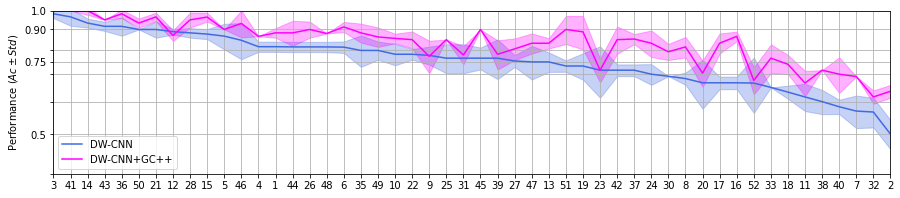

In [ ]:
#-------------------------------------------------------------------------------
# DW-CNN
Nsbj = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,
        26,27,28,30,31,32,33,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52])

acc_sbj = np.array([81.7,50.0,98.3,81.7,86.7,81.5,56.9,68.3,77.8,78.3,
           61.6,88.9,75.0,93.3,87.7,66.7,66.7,63.3,73.3,66.7, 
           90.0,78.3,71.6,70.0,76.6,81.6,75.4,88.3,69.2,76.6,
           56.6,65.0,80.0,91.6,71.6,60.0,76.6,58.3,96.6,71.6,
           91.6,81.6,76.6,84.7,75.0,81.6,80.0,90.0,73.3,66.6])

std_sbj = np.array([2.35,4.08,2.35,2.35,6.23,2.61,5.19,2.35,3.92,4.71,
           4.71,1.42,4.08,2.35,2.48,2.35,2.35,2.35,5.44,9.07,
           4.08,2.35,10.27,4.08,6.23,2.35,2.48,2.35,0.00,6.23,
           4.71,0.00,7.07,4.71,2.35,4.08,8.49,2.35,4.71,2.35,
           2.35,2.35,4.71,8.56,7.07,2.35,4.08,0.00,2.35,10.27])

idxs = np.argsort(acc_sbj)[::-1]
#-------------------------------------------------------------------------------
# Mask GradCam++
acc_mask_gradcam = np.array([88.3,63.6,100.0,86.6,90.0,91.3,69.1,81.6,77.4,85.6,66.6,87.0,83.3,100.0,96.5,86.6,83.3,74.0,88.8,70.4,96.6,85.0,71.6,83.3,85.0,
                    90.0,80.7,95.0,79.4,78.0,61.6,76.6,88.3,98.3,85.3,71.6,78.3,70.0,100.0,85.0,95.0,88.3,90.0,93.1,83.3,88.0,86.3,93.3,90.0,67.6])

std_mask_gradcam = np.array([2.4,2.3,0.0,0,0.0,2.6,0.0,4.7,7.1,2.3,4.7,2.6,2.4,2.3,2.4,2.3,4.7,4.0,8.3,5.2,2.3,4.0,4.7,6.2,0.0,
                    4.1,4.9,4.0,3.6,4.0,2.3,6.2,4.7,2.3,2.4,0.0,6.4,7.0,0.0,6.5,0.0,6.2,0.0,7.0,4.7,0.0,4.7,2.4,7.1,5.1])
#-------------------------------------------------------------------------------
#print('Acc FBCSP:',np.mean(acc),np.mean(stds),np.sum(acc<=70))
print('Acc DW-CNN:',np.mean(acc_sbj),np.mean(std_sbj),np.sum(acc_sbj<=70))
print('Acc DW-CNN+GC++:',np.mean(acc_mask_gradcam),np.mean(std_mask_gradcam),np.sum(acc_mask_gradcam<=70))
# figure
plt.figure(figsize=(15,3))
plt.ylabel('Performance ($Ac\pm Std$)')
# plot train scores
plt.plot(np.arange(50), acc_sbj[idxs], label='Average test accuracy',
             color='royalblue')
# create a shaded area between [mean - std, mean + std]
plt.gca().fill_between(np.arange(50),
                       acc_sbj[idxs] - std_sbj[idxs],
                       acc_sbj[idxs] + std_sbj[idxs],
                       alpha=0.3,
                       color='royalblue')

plt.plot(np.arange(50), acc_mask_gradcam[idxs], label='Average test mask GC',
             color='magenta')
plt.gca().fill_between(np.arange(50),
                       np.array(acc_mask_gradcam)[idxs] - np.array(std_mask_gradcam)[idxs],
                       np.array(acc_mask_gradcam)[idxs] + np.array(std_mask_gradcam)[idxs],
                       alpha=0.3,
                       color='magenta')

#plt.bar(np.arange(50), height=110, width=0.8,color='lightcoral',alpha=0.3)

plt.grid()
plt.xlim((0,49))
plt.xticks(np.arange(50),Nsbj[idxs])
plt.ylim((40,100))
plt.yscale('log')
plt.yticks((40,50,60,70,75,80,90,100),['','0.5','','','0.75','','0.90','1.0'])
plt.legend(['DW-CNN','DW-CNN+GC++'],loc='lower left')#,'DW-CNN GC++','DW-CNN SC'
plt.savefig('/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/new_figures/Accuracy_improved_sbjs.svg', format='svg')

In [ ]:
Nsbj = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,
        26,27,28,30,31,32,33,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52])
tmp = np.concatenate((np.ones((1,1)),np.zeros((1,1))),axis=0)
plt.figure(figsize=(1,1))
plt.matshow(tmp)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/new_figures/tmp.svg', format='svg')

In [ ]:
#-------------------------------------------------------------------------------
corr_runs = [0.35947901,0.3062230984172442,0.4541952357866223,0.36574957877650216,0.30311743774342936,0.26498483009709595]
plt.figure(figsize=(15,3))
plt.bar(np.arange(6), height=corr_runs, width=0.8,color='royalblue',alpha=0.5)
plt.ylabel(r'$R^2$')
plt.xticks(np.arange(6),[r'$\tau_1$','Run 1','Run 2','Run 3','Run 4','Run 5'])
plt.ylim(0,0.5)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/new_figures/corr_vals.svg', format='svg')
plt.show()
#-------------------------------------------------------------------------------

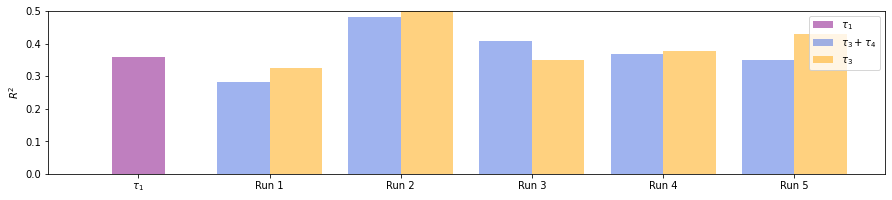

In [ ]:
#-------------------------------------------------------------------------------
corr_runs_1 = [0.0,0.28340849161589565,0.48232202106630273,0.4081534549481999,0.36816802770541934,0.3483172950394735]
corr_runs_2 = [0.0,0.32458763658049783, 0.5039870295900108,0.3494501718640215,0.3778909258531019,0.42997783712605614]
corr_runs_0 = [0.35947901,0.0, 0.0,0.0,0.0,0.0]
plt.figure(figsize=(15,3))
plt.bar(np.arange(6)+.2, height=corr_runs_0, width=0.4,color='purple',alpha=0.5)
plt.bar(np.arange(6), height=corr_runs_1, width=0.4,color='royalblue',alpha=0.5)
plt.bar(np.arange(6)+.4, height=corr_runs_2, width=0.4,color='orange',alpha=0.5)
plt.ylabel(r'$R^2$')
plt.ylim(0,0.5)
plt.legend([r'$\tau_1$',r'$\tau_3+\tau_4$',r'$\tau_3$'])
plt.xticks(np.arange(6)+.2,[r'$\tau_1$','Run 1','Run 2','Run 3','Run 4','Run 5'])
plt.savefig('/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/new_figures/corr_vals.svg', format='svg')
plt.show()
#-------------------------------------------------------------------------------

In [ ]:
#-------------------------------------------------------------------------------
# DW-CNN
Nsbj = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,
        26,27,28,30,31,32,33,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52])

acc_sbj = np.array([81.7,50.0,98.3,81.7,86.7,81.5,56.9,68.3,77.8,78.3,
           61.6,88.9,75.0,93.3,87.7,66.7,66.7,63.3,73.3,66.7, 
           90.0,78.3,71.6,70.0,76.6,81.6,75.4,88.3,69.2,76.6,
           56.6,65.0,80.0,91.6,71.6,60.0,76.6,58.3,96.6,71.6,
           91.6,81.6,76.6,84.7,75.0,81.6,80.0,90.0,73.3,66.6])

std_sbj = np.array([2.35,4.08,2.35,2.35,6.23,2.61,5.19,2.35,3.92,4.71,
           4.71,1.42,4.08,2.35,2.48,2.35,2.35,2.35,5.44,9.07,
           4.08,2.35,10.27,4.08,6.23,2.35,2.48,2.35,0.00,6.23,
           4.71,0.00,7.07,4.71,2.35,4.08,8.49,2.35,4.71,2.35,
           2.35,2.35,4.71,8.56,7.07,2.35,4.08,0.00,2.35,10.27])

idxs = np.argsort(acc_sbj)[::-1]
#-------------------------------------------------------------------------------
acc_sbj_right = np.array([78.3,48.3,88.3,81.6,88.3,85.2,56.6,71.6,73.6,75.0,58.3,79.6,75.0,93.3,85.9,68.3,71.6,60.0,64.4,66.6,88.3,73.3,68.3,61.6,75.0,
                 73.3,71.9,75.0,69.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
#std_sbj_right = []

acc_sbj_left = np.array([78.3,46.6,91.6,76.6,81.6,77.7,61.1,66.6,79.7,80.0,60.0,77.7,73.3,96.6,77.1,58.3,55.0,60.0,77.7,66.6,83.3,66.6,68.3,68.3,75.0,
                 76.6,73.7,85.0,74.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
#-------------------------------------------------------------------------------
plt.figure(figsize=(15,3))
plt.plot(np.arange(50), acc_sbj_right[idxs],'bo')
plt.plot(np.arange(50), acc_sbj_left[idxs],'ro')
plt.grid()
plt.xlim((0,49))
plt.xticks(np.arange(50),Nsbj[idxs])
plt.ylim((40,100))
#plt.yscale('log')
#plt.yticks((40,50,60,70,75,80,90,100),['','0.5','','','0.75','','0.90','1.0'])
plt.legend(['Right side','Left side'])
plt.show()

Avg acc Class 0: 73.366
Avg acc Class 1: 71.516


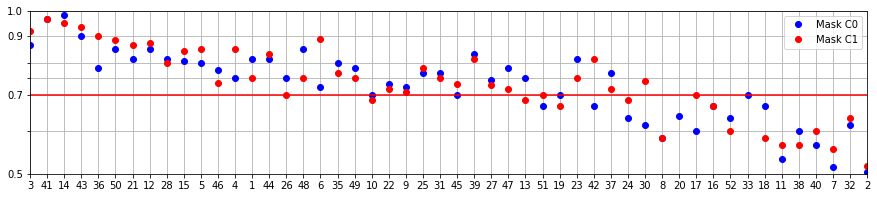

In [ ]:
#-------------------------------------------------------------------------------
# DW-CNN
Nsbj = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,
        26,27,28,30,31,32,33,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52])

acc_sbj = np.array([81.7,50.0,98.3,81.7,86.7,81.5,56.9,68.3,77.8,78.3,
           61.6,88.9,75.0,93.3,87.7,66.7,66.7,63.3,73.3,66.7, 
           90.0,78.3,71.6,70.0,76.6,81.6,75.4,88.3,69.2,76.6,
           56.6,65.0,80.0,91.6,71.6,60.0,76.6,58.3,96.6,71.6,
           91.6,81.6,76.6,84.7,75.0,81.6,80.0,90.0,73.3,66.6])

std_sbj = np.array([2.35,4.08,2.35,2.35,6.23,2.61,5.19,2.35,3.92,4.71,
           4.71,1.42,4.08,2.35,2.48,2.35,2.35,2.35,5.44,9.07,
           4.08,2.35,10.27,4.08,6.23,2.35,2.48,2.35,0.00,6.23,
           4.71,0.00,7.07,4.71,2.35,4.08,8.49,2.35,4.71,2.35,
           2.35,2.35,4.71,8.56,7.07,2.35,4.08,0.00,2.35,10.27])

idxs = np.argsort(acc_sbj)[::-1]
#-------------------------------------------------------------------------------
acc_sbj_c0 = np.array([81.6,50.3,86.6,75.0,80.0,72.2,51.4,58.3,72.2,70.0,
                      53.3,85.1,75.0,98.3,80.7,66.6,60.0,66.6,70.0,64.0,
                      81.6,73.3,81.6,63.3,76.6,75.0,74.6,81.6,
                      61.5,76.6,61.6,70.0,80.0,78.3,76.6,60.0,83.3,
                      56.6,96.6,66.6,90.0,81.6,70.0,77.7,78.3,85.0,78.3,
                      85.0,66.6,63.3])
print('Avg acc Class 0:', np.mean(acc_sbj_c0))
#std_sbj_right = []

acc_sbj_c1 = np.array([75.0,51.6,91.6,85.0,85.0,88.8,55.5,58.3,70.8,68.3,
                      56.6,87.0,68.3,95.0,84.2,66.6,70.0,58.3,66.6,0,
                      86.6,71.6,75.0,68.3,78.3,70.0,72.9,80.0,
                      74.3,75.0,63.3,0,76.6,90.0,71.6,56.6,81.6,
                      60.0,96.6,81.6,93.3,83.3,73.3,73.6,71.6,75.0,75.0,
                      88.3,70.0,60.0])
print('Avg acc Class 1:', np.mean(acc_sbj_c1))
#-------------------------------------------------------------------------------
plt.figure(figsize=(15,3))
plt.plot(np.arange(50), acc_sbj_c0[idxs],'bo')
plt.plot(np.arange(50), acc_sbj_c1[idxs],'ro')
plt.plot(np.arange(50), np.ones(50)*70.0, label='Average',
             color='red')
plt.grid()
plt.xlim((0,49))
plt.xticks(np.arange(50),Nsbj[idxs])
plt.ylim((50,100))
plt.yscale('log')
plt.yticks((50,60,70,75,80,90,100),['0.5','','0.7','','','0.9','1.0'])
plt.legend(['Mask C0','Mask C1'])
plt.savefig('/content/drive/MyDrive/Colab Notebooks/GradCam_Paper/GigaData/results/new_figures/Acc_mask.svg', format='svg')
plt.show()

In [ ]:
new_mask_c0 = acc_sbj_c0[idxs]
new_mask_c1 = acc_sbj_c1[idxs]
print('GI class 0:',np.mean(new_mask_c0[:13]))
print('GI class 1:',np.mean(new_mask_c1[:13]))

GI class 0: 84.34615384615384
GI class 1: 87.4
